# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import matplotlib.pyplot as plt
import ast
from time import time
import pandas as pd
import seaborn as sns
import pandas as pd
#import workspace_utils.py

from workspace_utils import active_session
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier



 
# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data

with active_session():    
        azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
        customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

        #this csv file has been created manually,this sorts features alphabetically,while mapping both type and corresponding values to missing information of each feauture 
        feature_information = pd.read_csv('./manually_created_csv.csv', sep=';', names=['Feature', 'Type', 'Unknown'])


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
def reach_feat(feature_type,df=feature_information):
    """
    Reach features of a specific type mentioned in the parameter.

    INPUT:
    - feature_type : the type of the feature
    
    - df (dataframe) : the dataframe to be reached
   
    """
    
    for i in range (0, df.shape[0]):
        type_f = df.at[i,'Type']
        feat = df.at[i,'Feature']
        try:
            if(type_f == feature_type):
                print("feature")
                print(feat, azdias.loc[: , feat].unique())
        except KeyError:
            
            print(feat + ' isnt reach able')
            
def dataframe_split(dataframe, missing_values_row, t=0.3):
    """
    This functions now splits the dataframe into two different parts based on the missing values

    INPUT:
    - dataframe: DataFrame that needs to be split
    - missing_values_row:  missing values per row
    - t : threshold for splitting

    OUTPUT:
    - above_t: DataFrame which has a missing values less than t 
    - below_t: DataFrame  which has a missing values more than t 
    """
    
    above_t = dataframe[missing_values_row / dataframe.shape[1] <= t]
    below_t = dataframe[missing_values_row / dataframe.shape[1] > t]
    return above_t, below_t
    

def convert_to_decades(PRAEGENDE_JUGENDJAHRE_value):
    """
    change  feature PRAEGENDE_JUGENDJAHRE to a DECADE value.

    INPUT:
    - PRAEGENDE_JUGENDJAHRE_value (int): the original data

    OUTPUT:
    - result : new value (0: 40s, 1: 50s, 2: 60s, 3: 70s, 4: 80s, 5: 90s)
    """
    
    result = PRAEGENDE_JUGENDJAHRE_value
    if (PRAEGENDE_JUGENDJAHRE_value > 0 and PRAEGENDE_JUGENDJAHRE_value <= 2):
        result = 0 
    elif (PRAEGENDE_JUGENDJAHRE_value <= 4):
        result = 1 
    elif (PRAEGENDE_JUGENDJAHRE_value <= 7):
        result = 2 
    elif (PRAEGENDE_JUGENDJAHRE_value <= 9):
        result = 3 
    elif (PRAEGENDE_JUGENDJAHRE_value <= 13):
        result = 4 
    elif (PRAEGENDE_JUGENDJAHRE_value <= 15):
        result = 5 
    return result

def convert_to_movement(PRAEGENDE_JUGENDJAHRE_value):
    """
    change  feature PRAEGENDE_JUGENDJAHRE to a MOVEMENT value.

    INPUT:
    - PRAEGENDE_JUGENDJAHRE_value (int): the original data

    OUTPUT:
    - result: new value (0: Mainstream, 1: Avantgarde)
    """
    
    result = PRAEGENDE_JUGENDJAHRE_value
    if (PRAEGENDE_JUGENDJAHRE_value in [1,3,5,8,10,12,14]):
        #Mainstream
        result = 0 
    elif (PRAEGENDE_JUGENDJAHRE_value in [2,4,6,7,9,11,13,15]):
        #Avantgarde
        result = 1 
    return result

In [4]:

azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [5]:
 
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [6]:

azdias.head(10)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
5,910244,3,1.0,10.0,NaN,NaN,NaN,NaN,10.0,5.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1
6,910248,-1,9.0,0.0,NaN,NaN,NaN,NaN,NaN,4.0,...,2.0,7.0,10.0,10.0,3.0,9.0,5.0,4,2,2
7,910261,-1,1.0,14.0,NaN,NaN,NaN,NaN,14.0,6.0,...,2.0,10.0,12.0,9.0,5.0,9.0,1.0,1,1,1
8,645145,-1,9.0,16.0,NaN,NaN,NaN,NaN,16.0,2.0,...,4.0,8.0,11.0,8.0,5.0,8.0,1.0,6,1,3
9,645153,-1,5.0,17.0,NaN,NaN,NaN,NaN,17.0,9.0,...,4.0,1.0,1.0,1.0,4.0,3.0,7.0,4,2,3


In [7]:

customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB


In [8]:

customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


In [9]:

customers.head(10)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3
5,143888,1,1.0,11.0,NaN,NaN,NaN,NaN,10.0,1.0,...,1.0,6.0,9.0,1.0,2,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,3
6,143904,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,1,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
7,143910,1,1.0,10.0,NaN,NaN,NaN,NaN,9.0,1.0,...,1.0,6.0,9.0,3.0,3,FOOD,SINGLE_BUYER,0,1,4
8,102160,2,3.0,5.0,NaN,NaN,NaN,NaN,4.0,74.0,...,9.0,6.0,3.0,4.0,3,COSMETIC,MULTI_BUYER,0,2,4
9,102173,1,1.0,20.0,NaN,NaN,NaN,NaN,13.0,1.0,...,4.0,2.0,9.0,5.0,1,COSMETIC,MULTI_BUYER,0,1,3


### Preprocessing azidas 

In [10]:
 
feature_information

,Feature,Type,Unknown
0,AGER_TYP,categorical,"[-1,0]"
1,ALTERSKATEGORIE_FEIN,ordinal,"[-1,0.9]"
2,ALTERSKATEGORIE_GROB,ordinal,"[-1,0,9]"
3,ALTER_HH,ordinal,[0]
4,ANREDE_KZ,categorical,"[-1,0]"
5,ANZ_HAUSHALTE_AKTIV,numeric,[]
6,ANZ_HH_TITEL,numeric,[]
7,ANZ_KINDER,numeric,[]
8,ANZ_PERSONEN,numeric,[]
9,ANZ_STATISTISCHE_HAUSHALTE,numeric,[]


In [11]:
with active_session(): 
    feature_list = feature_information['Feature'].tolist()

In [12]:
#the last 5 records

feature_information.tail()

,Feature,Type,Unknown
329,VERS_TYP,categorical,[-1]
330,WOHNDAUER_2008,ordinal,"[-1,0]"
331,WOHNLAGE,ordinal,"[-1,0]"
332,W_KEIT_KIND_HH,ordinal,"[-1,0]"
333,ZABEOTYP,categorical,"[-1,9]"


In [13]:
#the first five records

feature_information.head()

,Feature,Type,Unknown
0,AGER_TYP,categorical,"[-1,0]"
1,ALTERSKATEGORIE_FEIN,ordinal,"[-1,0.9]"
2,ALTERSKATEGORIE_GROB,ordinal,"[-1,0,9]"
3,ALTER_HH,ordinal,[0]
4,ANREDE_KZ,categorical,"[-1,0]"


## Lets Start with the Data Preprocessing for Azdias
Step 1 :- Do something about the difference in the number of features between the dataset AZDIAS and the manually_created_csv dataset

In [14]:
with active_session():   
    diff_between_feature_list_and_azidas = list(set(feature_list) - set(azdias))
    diff_between_azidas_feature_list = list(set(azdias) - set(feature_list))
    diff_between_customers_azdias = list(set(customers) - set(azdias))

    diff1=len(diff_between_feature_list_and_azidas)
    diff2=len(diff_between_azidas_feature_list)
    diff3=len(diff_between_customers_azdias)


    print('Features in feature_list that are not a part of azdias:')
    print("Number of features are",diff1)
    print(diff_between_feature_list_and_azidas)
    print('-------------------------------------------------------------------------------------')



    print('Features in azdias that are not in feat_list:')
    print("Number of features part of azidas and not in feature list",diff2)
    print(diff_between_azidas_feature_list)
    print('-------------------------------------------------------------------------------------')



    print('Features in customers that are not in azdias:')
    print("Number of features part of customers and not in azdias list",diff3)
    print(diff_between_customers_azdias)
    print('-------------------------------------------------------------------------------------')

Features in feature_list that are not a part of azdias:
Number of features are 0
[]
-------------------------------------------------------------------------------------
Features in azdias that are not in feat_list:
Number of features part of azidas and not in feature list 32
['CJT_KATALOGNUTZER', 'ALTER_KIND3', 'VK_DHT4A', 'CJT_TYP_5', 'EXTSEL992', 'GEMEINDETYP', 'KOMBIALTER', 'CJT_TYP_4', 'VK_ZG11', 'CJT_TYP_6', 'D19_KONSUMTYP_MAX', 'EINGEFUEGT_AM', 'ALTER_KIND2', 'RT_SCHNAEPPCHEN', 'CJT_TYP_2', 'VHA', 'D19_LETZTER_KAUF_BRANCHE', 'STRUKTURTYP', 'LNR', 'VHN', 'UMFELD_ALT', 'VERDICHTUNGSRAUM', 'CJT_TYP_3', 'ALTER_KIND4', 'VK_DISTANZ', 'RT_UEBERGROESSE', 'FIRMENDICHTE', 'UMFELD_JUNG', 'ALTER_KIND1', 'CJT_TYP_1', 'RT_KEIN_ANREIZ', 'AKT_DAT_KL']
-------------------------------------------------------------------------------------
Features in customers that are not in azdias:
Number of features part of customers and not in azdias list 3
['ONLINE_PURCHASE', 'PRODUCT_GROUP', 'CUSTOMER_GROUP'

In [15]:
#before dropping

azdias.shape

(891221, 366)

In [16]:
# drop features
with active_session(): 
    azdias.drop(labels=diff_between_azidas_feature_list, axis=1, inplace=True)

In [17]:
#after dropping
 
azdias.shape

(891221, 334)

## Step 2 :- Do something about all the missing values
use the manually created CSV file to replace missing values in azdias with NAN, so that machine learning algorithms can better perform

In [18]:
'''The manually created file has some missing information,we better convert them to NAN'''
with active_session(): 
    unknown_values = pd.Series(feature_information['Unknown'].values, index=feature_information['Feature'])


In [19]:
#top 5 unknown vakues
 
unknown_values.head()

Feature
AGER_TYP                  [-1,0]
ALTERSKATEGORIE_FEIN    [-1,0.9]
ALTERSKATEGORIE_GROB    [-1,0,9]
ALTER_HH                     [0]
ANREDE_KZ                 [-1,0]
dtype: object

In [20]:
with active_session(): 
    for column in azdias:
        isin = ast.literal_eval(unknown_values[column])
        #here in the next step we insert NAN in place of the missing columns
        azdias[column] = azdias[column].mask(azdias[column].isin(isin), other=np.nan)



In [21]:
#azdias after inserting NAN
 
azdias.head()

,AGER_TYP,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,SOHO_KZ,TITEL_KZ,UNGLEICHENN_FLAG,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2.0
1,NaN,NaN,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,1.0,NaN,1.0,2.0,3.0,9.0,4.0,5,2,1.0
2,NaN,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,0.0,NaN,0.0,1.0,3.0,9.0,2.0,5,2,3.0
3,2.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,0.0,NaN,0.0,1.0,NaN,9.0,7.0,3,2,4.0
4,NaN,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,0.0,NaN,0.0,2.0,2.0,9.0,3.0,4,1,3.0


## STEP 3:-Deal with those features that have a very high value of NANs
Here arises a question of picking a threshold, now on what logic do we pick a threshold to drop features so that, we lose the most NANs and least amount of data is lost to us

In [22]:
# Now its possible that some columns might just have too many NaNs and we might not derive a lot of information from it
#therefore its a better decision to drop it
with active_session(): 
    missing_values = azdias.isnull().mean()

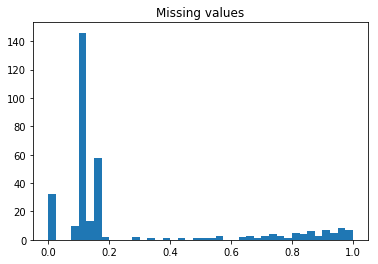

In [23]:
with active_session(): 
    plt.hist(missing_values, bins=40)
    plt.title("Missing values")

In [24]:
# Now lets set the thresholdat 80% and retain any col which has about 80% data in it
with active_session(): 
    drop_missing_values = missing_values[missing_values > 0.2].index
    azdias.drop(labels=drop_missing_values, axis=1, inplace=True)

In [25]:
print("Number of columns dropped are",len(drop_missing_values))

Number of columns dropped are 73


In [26]:
#shape of azdias after dropping the columns
print("shape of azdias after dropping the columns",azdias.shape)

shape of azdias after dropping the columns (891221, 261)


## STEP 4:- Let's drop those rows which have a high percentage of NANs
Now once again the same question arises, how do we pick a threshold value?

In [27]:
# Now its possible that some rows also might just have too many NaNs and we might not derive a lot of information from it
#therefore its a better decision to drop it
with active_session(): 
    missing_values_row = azdias.isnull().sum(axis=1)

In [28]:
print("Number of rows with too many NaNs",len(missing_values_row))

Number of rows with too many NaNs 891221


a graph of number of graphs V/S missing values per row would suggest that 0.3 is a good pick as seen below

(array([  6.54805000e+05,   3.21760000e+04,   3.39930000e+04,
          1.46810000e+04,   9.99000000e+02,   5.42000000e+02,
          8.40000000e+01,   7.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          5.60000000e+01,   8.77900000e+03,   3.24900000e+03,
          9.50100000e+03,   1.60590000e+04,   8.59000000e+02,
          3.69800000e+03,   4.85900000e+03,   6.04000000e+02,
          2.05000000e+02,   2.11000000e+02,   4.80000000e+01,
          3.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          5.06000000e+02,   9.50000000e+01,   3.80000000e+01,
        

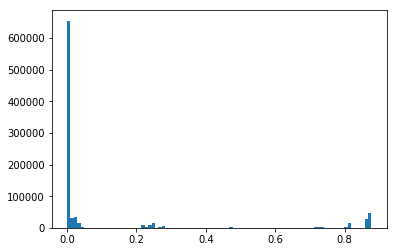

In [29]:
v=missing_values_row / azdias.shape[1]
plt.hist(v, bins=90)

In [30]:
with active_session(): 
    azdias, azdias_row_nan = dataframe_split(azdias, missing_values_row,0.3)

lets look at the new shape after dropping

In [31]:
print("shape of azdias after dropping the rows above a threshold of 30%",azdias.shape)
print("shape of azdias after dropping the rows below a threshold of 30%",azdias_row_nan.shape)

shape of azdias after dropping the rows above a threshold of 30% (785157, 261)
shape of azdias after dropping the rows below a threshold of 30% (106064, 261)


## STEP 5:- Features have to be re-encoded for better performance


In [32]:
'''now lets take a look at the categorical information we have with us in the feature_importance'''
with active_session(): 
    categorical_information = feature_information[feature_information['Type'] == 'categorical']


In [33]:
print('the shape of categorical_information is ',categorical_information.shape)

the shape of categorical_information is  (26, 3)


In [34]:
with active_session(): 
    col_owkz = azdias.loc[: , 'OST_WEST_KZ']
    s_owkz = pd.Series(col_owkz)
    OST_WEST_KZ_dropped = azdias.drop('OST_WEST_KZ', axis=1)
    the_one_with_dummies = pd.get_dummies(s_owkz, dummy_na=True, drop_first=True)
    azdias = pd.concat([OST_WEST_KZ_dropped,the_one_with_dummies], axis=1)

    azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].astype('float64')
    azdias.drop(['CAMEO_DEU_2015', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN'], axis=1, inplace=True)


with active_session(): 
    reach_feat('categorical')

feature
AGER_TYP isnt reach able
feature
ANREDE_KZ [2 1]
feature
CAMEO_DEUG_2015 [  8.   4.   2.   6.   1.   9.   5.   7.   3.  nan]
feature
CAMEO_DEU_2015 isnt reach able
feature
CJT_GESAMTTYP [  5.   3.   2.   4.   1.   6.  nan]
feature
D19_KONSUMTYP isnt reach able
feature
DSL_FLAG [ 1.  0.]
feature
FINANZTYP [1 6 5 2 4 3]
feature
GEBAEUDETYP [ 8.  1.  3.  2.  6.  4.  5.]
feature
GFK_URLAUBERTYP [ 10.   1.   5.  12.   9.   3.   8.  11.   4.   7.   2.   6.  nan]
feature
GREEN_AVANTGARDE [0 1]
feature
HH_DELTA_FLAG [  0.  nan   1.]
feature
KK_KUNDENTYP isnt reach able
feature
KONSUMZELLE [  1.   0.  nan]
feature
LP_FAMILIE_FEIN isnt reach able
feature
LP_FAMILIE_GROB [  3.   1.  nan   5.   2.   4.]
feature
LP_STATUS_FEIN isnt reach able
feature
LP_STATUS_GROB [  1.   2.   4.   5.   3.  nan]
feature
NATIONALITAET_KZ [  1.   3.   2.  nan]
feature
OST_WEST_KZ isnt reach able
feature
SHOPPER_TYP [  3.   2.   1.   0.  nan]
feature
SOHO_KZ [ 1.  0.]
feature
TITEL_KZ isnt reach able
feature


In [35]:
#now lets do the same for mixed as well
with active_session(): 
    mixed_information = feature_information[feature_information['Type'] == 'mixed']

    reach_feat('mixed')

feature
CAMEO_INTL_2015 [51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0 nan
 23.0 31.0 52.0 35.0 45.0 44.0 32.0 '22' '24' '41' '12' '54' '51' '44' '35'
 '23' '25' '14' '34' '52' '55' '31' '32' '15' '13' '43' '33' '45']
feature
LP_LEBENSPHASE_FEIN [ 21.   3.  nan  32.   8.   2.   5.  10.   4.   6.  23.  20.   1.  25.  13.
  18.  31.  38.  35.  30.   7.  22.  14.  29.  24.  28.  37.  26.  12.  39.
  27.  36.   9.  34.  33.  15.  11.  40.  16.  19.  17.]
feature
LP_LEBENSPHASE_GROB [  6.   1.  nan  10.   2.   3.   5.   7.  12.  11.   9.   4.   8.]
feature
PRAEGENDE_JUGENDJAHRE [ 14.  15.   8.   3.  10.  11.   9.   6.   4.  nan   5.   2.   1.  12.  13.
   7.]


In [36]:
with active_session(): 
    azdias['DECADE_NEW'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: convert_to_decades(x))
    azdias['MOVEMENT_NEW'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: convert_to_movement(x))


In [37]:
with active_session(): 
    azdias['WEALTH_NEW'] = azdias['CAMEO_INTL_2015'].apply(lambda x: np.floor(pd.to_numeric(x)/10))
    azdias['LIFE_STAGE_NEW'] = azdias['CAMEO_INTL_2015'].apply(lambda y: pd.to_numeric(y)%10)

In [38]:
with active_session():    
    azdias.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    azdias.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    azdias.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'], axis=1, inplace=True)

In [39]:
print("the new shape of azdias after all the tranformations being over is",azdias.shape)

the new shape of azdias after all the tranformations being over is (785157, 259)


### feature Scaling
Now we have a lot of nans still left with us and it is a better decision to fill them with values

## STEP 6:-  let's build a scaler and an imputer to handle the missing data
At this point there were still a lot of missing values let, these were imputed with the meridian of the corresponding feature and then the features were standardized.

This data was further stored in a dataframe that was called azdias_scaled which was used for further calculations.

In [40]:
len(azdias)

785157

In [41]:
#lets impute azdias
with active_session():
    imputer = Imputer(strategy='median')
    azdias_imputed = pd.DataFrame(imputer.fit_transform(azdias))




In [42]:
#lets scale azdias
with active_session():
    scaler = StandardScaler()
    azdias_scaled = scaler.fit_transform(azdias_imputed)

In [43]:
def clean_this_dataframe(dataframe, feature_information, drop_not_present, drop_nan_columns, split=False):
    """
    Cleans the DataFrame (this function basically does all the tasks that we have done before when this function is called,but does
    it all in a single function)

    INPUT:
    - dataframe (DataFrame): the DataFrame to be cleaned
    - feature_information (DataFrame): the DataFrame containing the feature information
    - drop_not_present (list): list of features to be dropped because they are not contained in the feature info
    - drop_nan_columns (list): list of features to be dropped because of a high percentage of missing values
    - split (bool): if True rows with a high percentage of missing values are extracted

    OUTPUT:
    - DataFrame: cleaned DataFrame
    - DataFrame (only if split=True): DataFrame containing rows with many missing values
    """
    
    
    dataframe.drop(labels=drop_not_present, axis=1, inplace=True)
    
    
    unknown = pd.Series(feature_information['Unknown'].values, index=feature_information['Feature'])
    for column in dataframe:
        isin = ast.literal_eval(unknown[column])
        
        dataframe[column] = dataframe[column].mask(dataframe[column].isin(isin), other=np.nan)
    
    
    dataframe.drop(labels=drop_nan_columns, axis=1, inplace=True)
    
    
    dataframe_row_nan = pd.DataFrame()
    if(split):
        
        missing_row_nan = dataframe.isnull().sum(axis=1)
        
        dataframe, dataframe_row_nan = dataframe_split(dataframe, missing_row_nan)
    
   
    col_owkz = dataframe.loc[: , 'OST_WEST_KZ']
    s_owkz = pd.Series(col_owkz)
    dataframe = pd.concat([dataframe.drop('OST_WEST_KZ', axis=1), pd.get_dummies(s_owkz, dummy_na=True, drop_first=True)], axis=1)

    
    dataframe.drop(['CAMEO_DEU_2015', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN'], axis=1, inplace=True)

    
    dataframe['CAMEO_DEUG_2015'] = dataframe['CAMEO_DEUG_2015'].astype('float64')
    
    
    dataframe['DECADE_NEW'] = dataframe['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: convert_to_decades(x))
    dataframe['MOVEMENT_NEW'] = dataframe['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: convert_to_movement(x))

    
    dataframe.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

   
    dataframe['WEALTH_NEW'] = dataframe['CAMEO_INTL_2015'].apply(lambda x: np.floor(pd.to_numeric(x)/10))
    dataframe['LIFE_STAGE_NEW'] = dataframe['CAMEO_INTL_2015'].apply(lambda x: pd.to_numeric(x)%10)

   
    dataframe.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
 
    dataframe.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'], axis=1, inplace=True)
    
    if(split):
        return dataframe, dataframe_row_nan
    else:
        return dataframe

### Data Preprocessing For Customers

In [44]:
with active_session(): 
    customers.drop(diff_between_customers_azdias, axis=1, inplace=True)

In [45]:
with active_session(): 
    customers, customers_row_nan = clean_this_dataframe(customers, feature_information, diff_between_azidas_feature_list, drop_missing_values, split=True)
    

In [46]:
customers.shape

(140343, 259)

In [47]:

customers.shape[0]/191652

0.7322803831945401

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [48]:
def make_a_scree_plot(pca_init):
    """
    This function will create a scree plot  
    INPUT:
    - pca_init : an initialized pca instance
    """
    
    
    ind = np.arange(len(pca_init.explained_variance_ratio_))
    
    values = pca_init.explained_variance_ratio_
 
    plt.figure(figsize=(41, 25))
    ax = plt.subplot(111)
    cumvalues = np.cumsum(values)
    
    ax.bar(ind, values)
    ax.plot(ind, cumvalues)
    for i in range(len(pca_init.explained_variance_ratio_)):
        
        ax.annotate(r"%s%%" % ((str(values[i]*100)[:4])), (ind[i]+0.2, values[i]), va="bottom", ha="center", fontsize=14)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    ax.set_ylabel("The Variance Explained In Terms Of Percentage",fontsize = 20)
    ax.set_xlabel("The Principal Component",fontsize = 20)
    
    plt.title('Variance V/S Principal Component',fontsize = 20)


now lets start applying PCA

In [49]:
scaled_azdias = azdias_scaled

In [50]:
with active_session():
    pca_initialization = PCA()
    X_azdias_pca_complete = pca_initialization.fit_transform(scaled_azdias)
    

In [51]:
X_azdias_pca_complete

array([[  2.07778465e+00,   5.56482576e+00,  -5.09956696e+00, ...,
         -3.65339901e-12,  -1.04093143e-14,   6.60331605e-17],
       [ -2.60163874e+00,   2.10337577e+00,   1.51289676e+00, ...,
         -8.45828937e-11,  -7.09333269e-15,   1.60439911e-16],
       [ -5.96932490e+00,   2.22000905e-02,   1.34018544e+00, ...,
         -2.38470798e-11,  -4.07110998e-15,  -8.59257097e-17],
       ..., 
       [ -3.82984757e+00,  -3.75550032e-01,  -5.02943147e+00, ...,
          4.33631130e-16,   6.01626564e-17,   6.41592585e-18],
       [  8.37215910e+00,  -3.46840486e+00,  -5.54724990e+00, ...,
          6.41662190e-16,  -3.04854800e-16,  -3.85724974e-18],
       [ -1.57279500e+00,  -8.45481262e-01,   1.11422392e+00, ...,
         -3.83558383e-15,   1.46230211e-16,  -7.03744035e-18]])

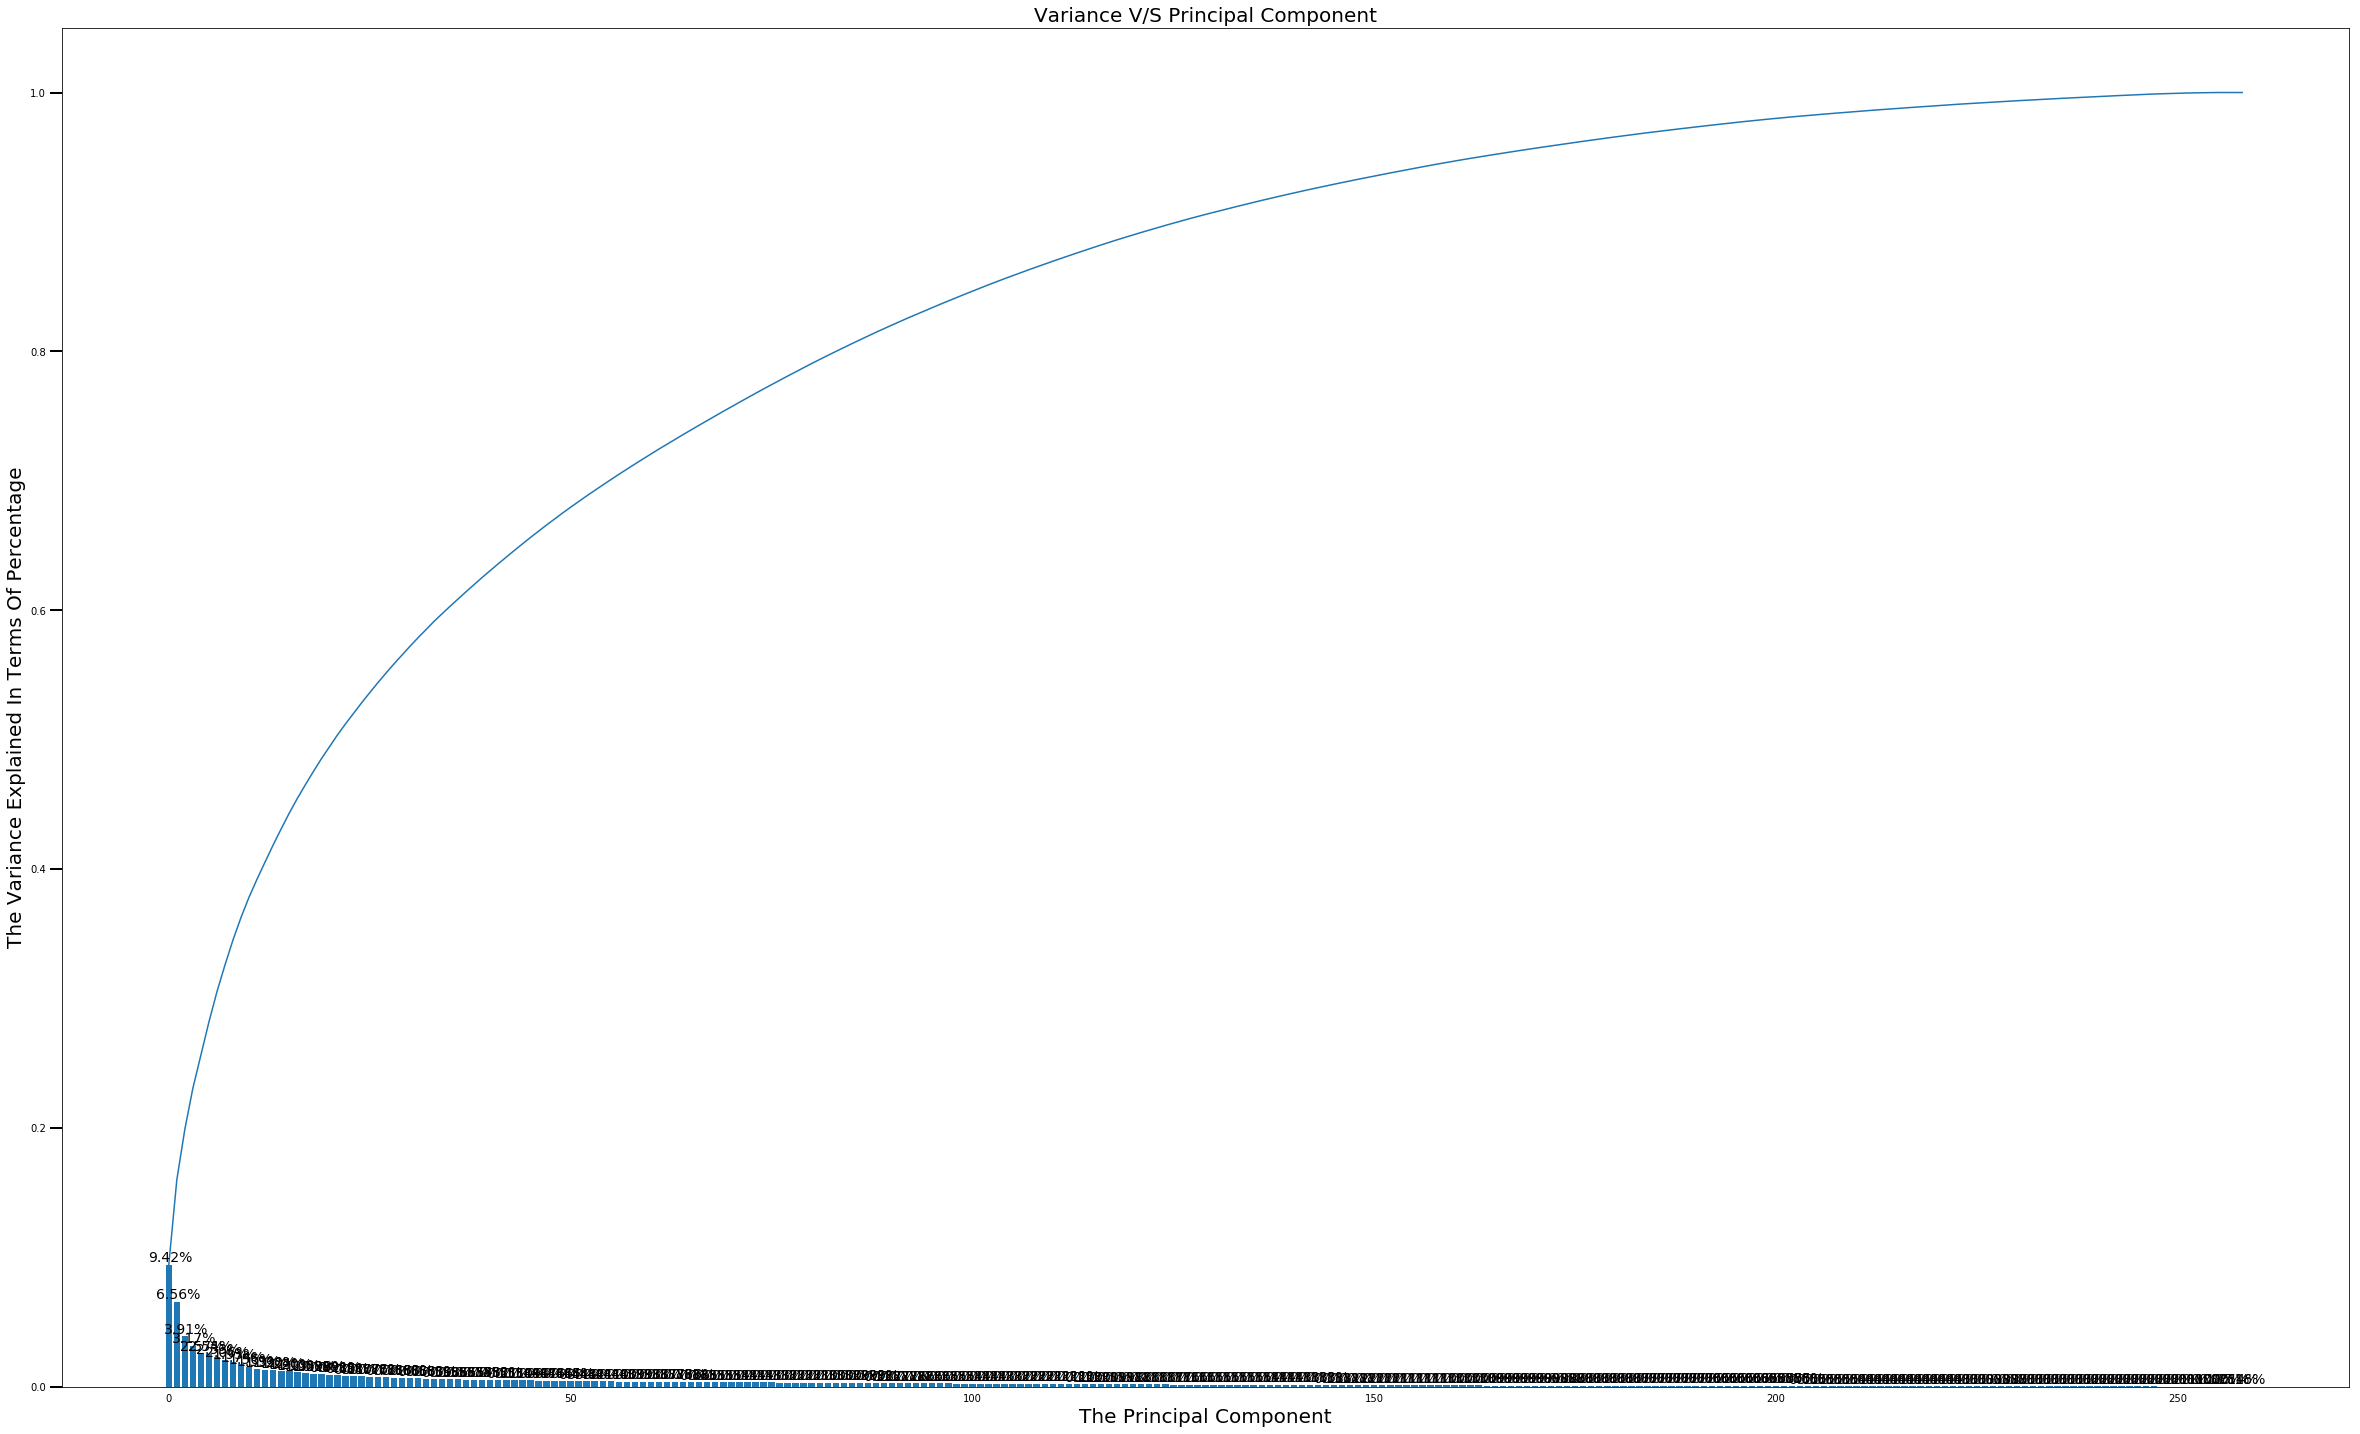

In [52]:
with active_session(): 
    make_a_scree_plot(pca_initialization)

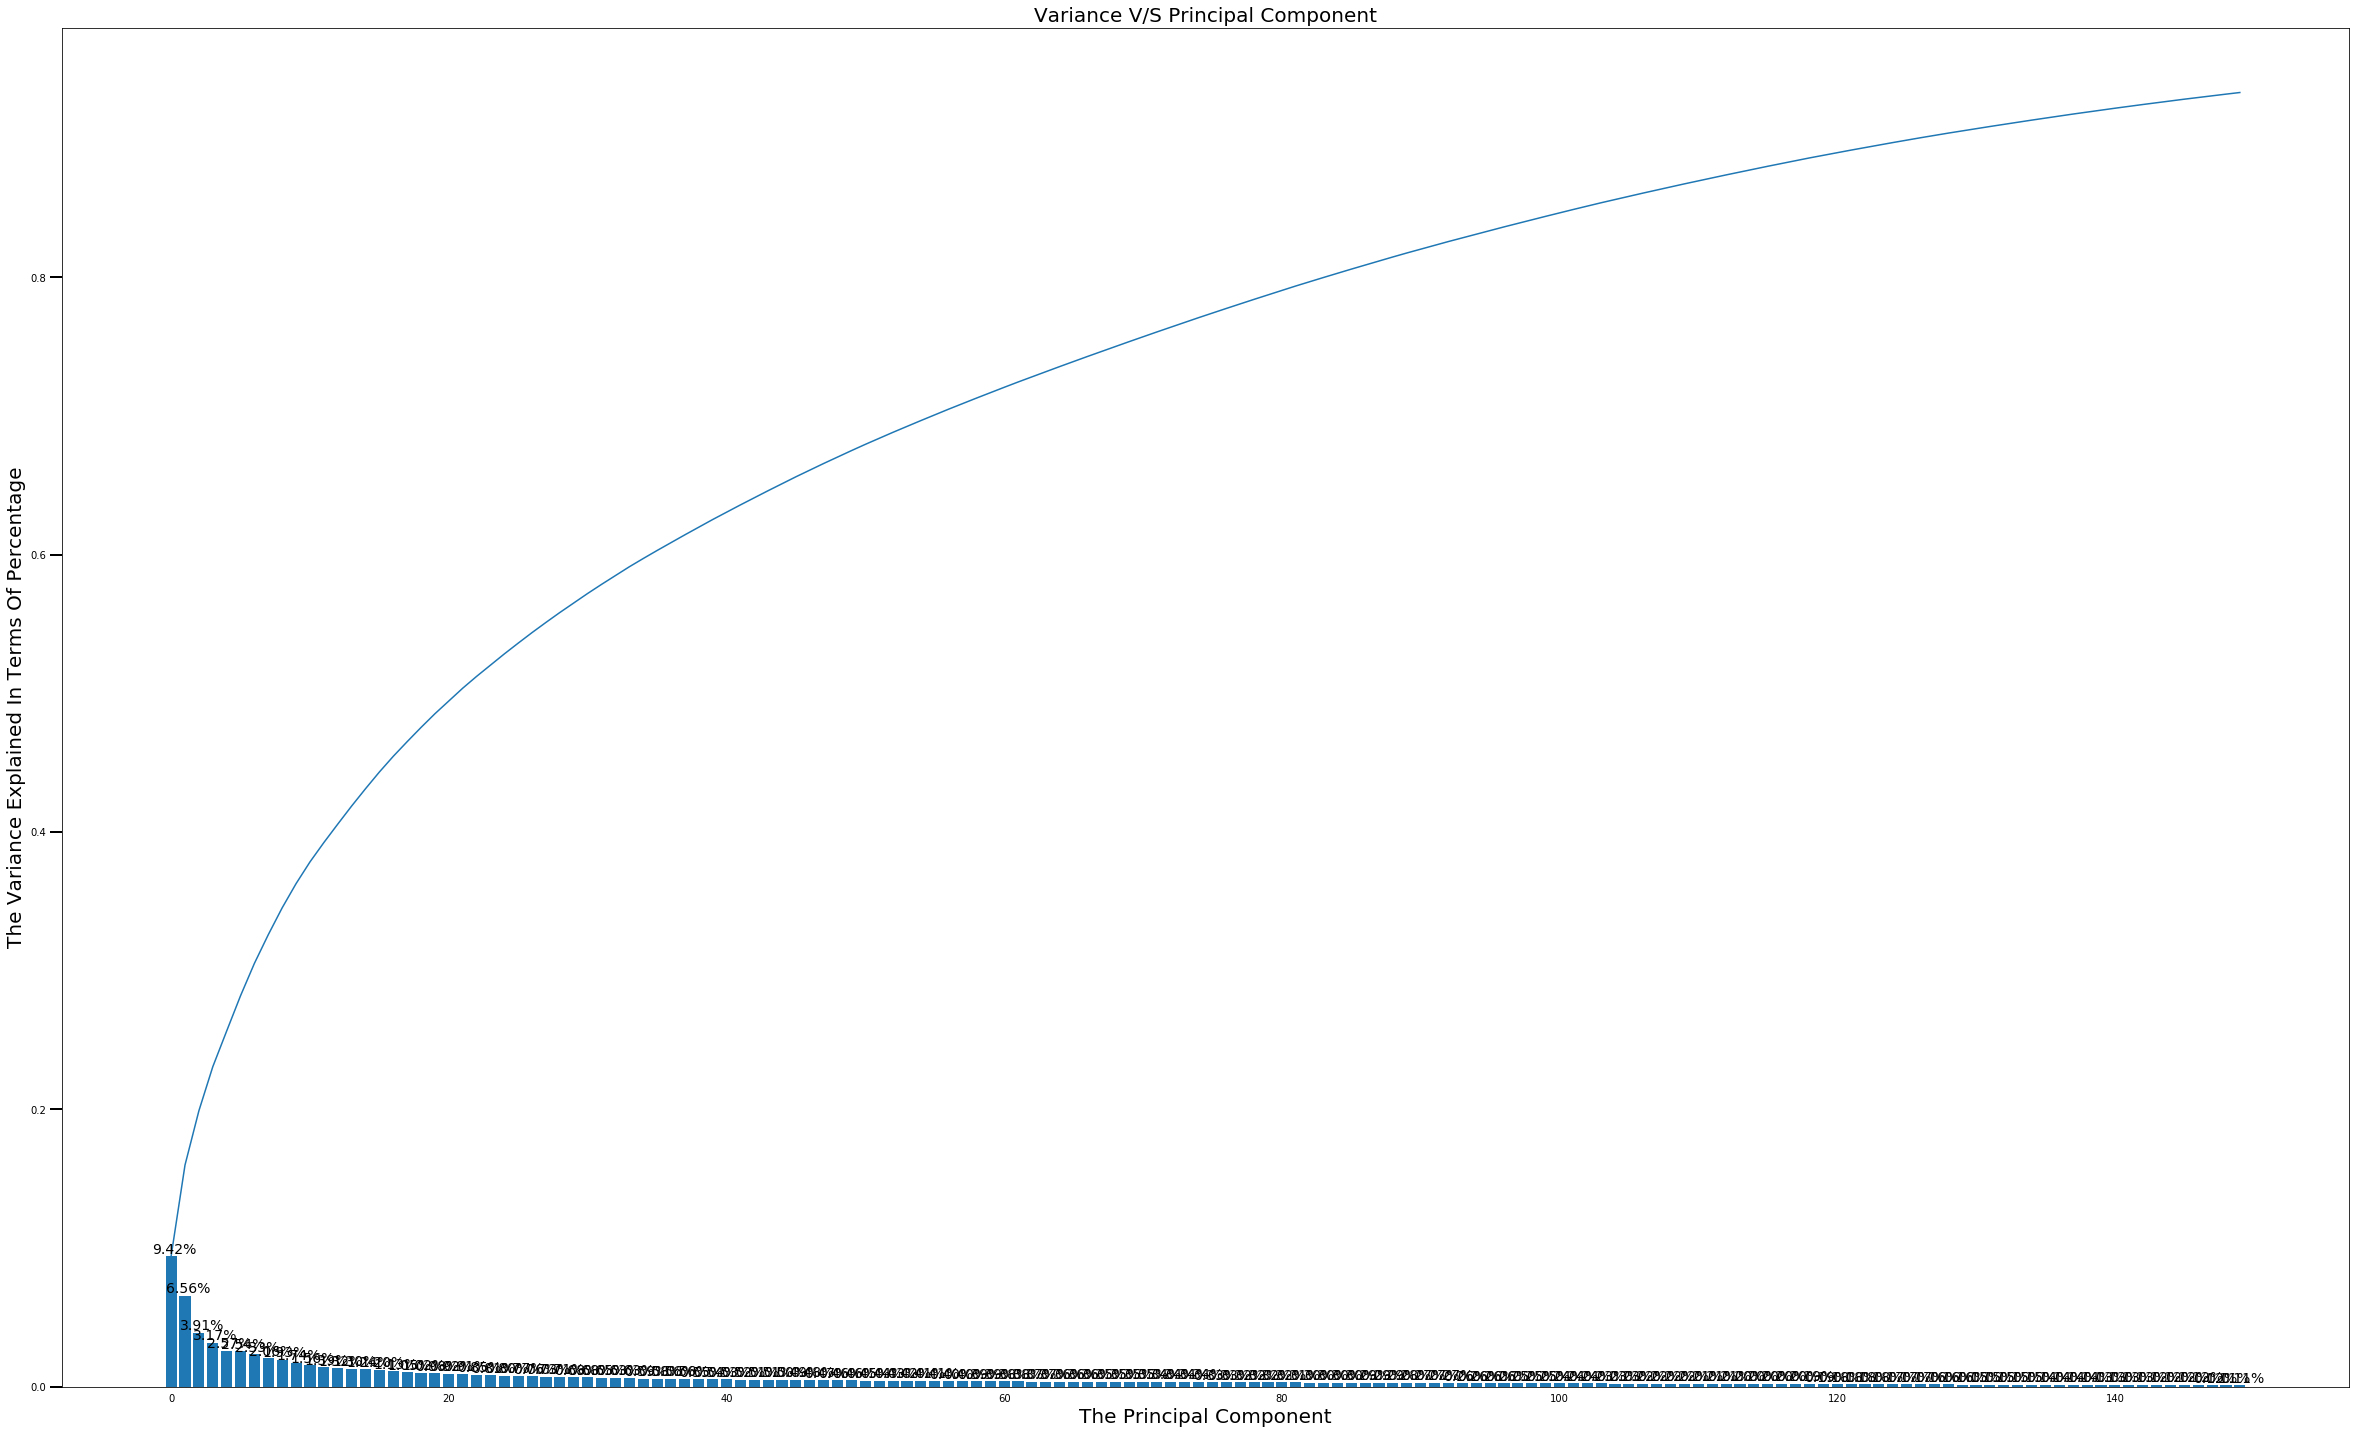

In [53]:
with active_session():
    pca_new = PCA(n_components=150, random_state=12)
    X_azdias_pca = pca_new.fit_transform(scaled_azdias)
    make_a_scree_plot(pca_new)

In [54]:
'''Now lets start by applying pca to the customers dataset'''

'Now lets start by applying pca to the customers dataset'

In [55]:
with active_session(): 
    customers_imputed = pd.DataFrame(imputer.transform(customers))
    customers_scaled = scaler.transform(customers_imputed)

In [56]:
with active_session():
    X_pca_customers = pca_new.transform(customers_scaled)

### NOW LETS USE KMEANS AND EVALUATE THE CLUSTERS FORMED

In [57]:
with active_session():    
    cluster_numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
    distances = []

    def apply_kmeans(data, cluster_number):
        """

        This function Computes the average distance between clusters

        INPUT:
        - data : the result of fit transform function
        - cluster_number (int): the number of clusters for which k means is run
        """
        with active_session(): 
            kmeans = KMeans(n_clusters=cluster_number, random_state=12)
            predicted_value = kmeans.fit_predict(data)
            predicted_centroids = kmeans.cluster_centers_
            center = predicted_centroids[predicted_value]
            distance = np.sqrt(((data - center) ** 2).sum(axis = 1)).mean()
            distances.append(distance)
            print("the distance for cluster number",cluster_number,"is",distance)


In [57]:
with active_session():
    for n in cluster_numbers:
        apply_kmeans(X_azdias_pca,n)

the distance for cluster number 1 is 15.3826785549
the distance for cluster number 2 is 14.7984994532
the distance for cluster number 3 is 14.5654709881
the distance for cluster number 4 is 14.397393289
the distance for cluster number 5 is 14.272152847
the distance for cluster number 6 is 14.1721159269
the distance for cluster number 7 is 14.0832835679
the distance for cluster number 8 is 14.0149773329
the distance for cluster number 9 is 13.9545693895
the distance for cluster number 10 is 13.9101164721
the distance for cluster number 11 is 13.8653234992
the distance for cluster number 12 is 13.8256391844
the distance for cluster number 13 is 13.7910574263
the distance for cluster number 14 is 13.7616352512
the distance for cluster number 15 is 13.733324757
the distance for cluster number 16 is 13.7023803484
the distance for cluster number 17 is 13.6898871008
the distance for cluster number 18 is 13.6584214986
the distance for cluster number 19 is 13.6345613286
the distance for cluster

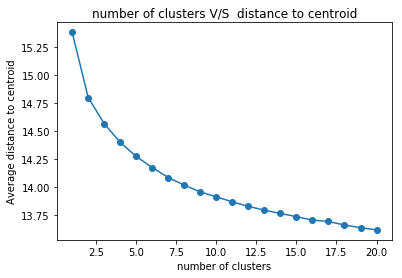

In [58]:
with active_session():
    plt.plot(cluster_numbers, distances, '-o')
    plt.ylabel('Average distance to centroid')
    plt.xlabel('number of clusters')
    plt.title('number of clusters V/S  distance to centroid')
    plt.show()

In [58]:
'''According to elbow methodthe optimal number of clusters is 9 '''
with active_session():
    kmeans = KMeans(n_clusters=9, random_state=12)
    azdias_predicted_value = kmeans.fit_predict(X_azdias_pca)
    azdias_predicted = kmeans.fit_predict(X_azdias_pca)

In [59]:
with active_session():  
    cluster__azdias = pd.DataFrame()
    cluster__azdias['data_index'] = azdias.index.values
    cluster__azdias['cluster'] = azdias_predicted

In [60]:
'''now lets use Kmeans for customers'''
with active_session():
    customers_predicted = kmeans.predict(X_pca_customers)

In [61]:
with active_session():    
    cluster__customers = pd.DataFrame()
    cluster__customers['data_index'] = customers.index.values
    cluster__customers['cluster'] = customers_predicted

'''Lets analysis this stuff now'''

In [62]:
with active_session():   
    azdias_helper_variable = azdias_row_nan.shape[0]
    customer_helper_variable = customers_row_nan.shape[0]

In [63]:
 with active_session():  
    azdias_unique, azdias_counts = np.unique(azdias_predicted, return_counts=True)
    azd_list = dict(zip(azdias_unique, azdias_counts / (azdias.shape[0] + azdias_helper_variable)))
    azd_list[9] = azdias_helper_variable/(azdias.shape[0] + azdias_helper_variable)

    customer_unique, customer_counts = np.unique(customers_predicted, return_counts=True)
    cst_list = dict(zip(customer_unique, customer_counts / (customers.shape[0] + customer_helper_variable)))
    cst_list[9] = customer_helper_variable/(customers.shape[0] + customer_helper_variable)

    print("That Azdias list",azd_list)
    print("That Customer list",cst_list)

That Azdias list {0: 0.063199812392212479, 1: 0.11858113756296138, 2: 0.092781700610735166, 3: 0.06739518032003286, 4: 0.12735898278878077, 5: 0.12629302945060764, 6: 0.068279360562643832, 7: 0.12702124388900171, 8: 0.090079789412502623, 9: 0.11900976301052152}
That Customer list {0: 0.091989647903491747, 1: 0.10598376223571891, 2: 0.014782000709619519, 3: 0.015705549642059568, 4: 0.29402249911297562, 5: 0.13640348130987415, 6: 0.021043349404128317, 7: 0.016018617076785008, 8: 0.036331475799887297, 9: 0.2677196168054599}


In [64]:
with active_session():    
    azdias_with_separated = azdias_predicted.copy()
    for i in range (0,azdias_helper_variable): 
        azdias_with_separated = np.append(azdias_with_separated, 9) 

    customer_with_separated = customers_predicted.copy()
    for i in range (0,customer_helper_variable): 
        customer_with_separated = np.append(customer_with_separated, 9) 

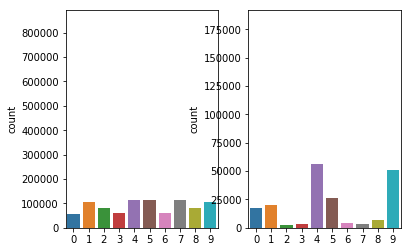

In [67]:
#now lets take a look into the cluster proportions
with active_session():
    lenght_azidas = azdias.shape[0]
    lenght_customers = customers.shape[0]
    ax1 = plt.subplot(121)
    ax1.set_ylim(0, lenght_azidas + azdias_helper_variable)
    sns.countplot(azdias_with_separated)

    ax2 = plt.subplot(122)
    ax2.set_ylim(0,lenght_customers  + customer_helper_variable)
    sns.countplot(customer_with_separated)

In [65]:
def binarize_the_clusters(cluster, cluster_map_dataframe):
    """
    this function changes the cluster pred to 0 if its not the target cluster,if not it gives 1
    
    INPUT:
    - cluster [int]: This parameter gives the information about the number of clusers
    - cluster_map [dataframe]: its a dataframe with index and cluster prediction
            
    OUTPUT:
    - DataFrame: It returns a dataframe which has values either 0 or 1 based on cluster
    """
    initial_variable = 333
    y = cluster_map_dataframe['cluster'].copy()
    y[y == cluster] = initial_variable
    y[y != initial_variable] = 0
    y[y == initial_variable] = 1
    return y


def fit_and_find_imp_feat(dataframe_which_is_scaled, predicted_dataframe, gridsearch_clf):
    """
    This fuction prints the most important features based on the classifiers coefficients
    
    INPUT:
    - dataframe_which_is_scaled (DataFrame): this function takes a dataframe which has standarized values
    - predicted_dataframe (DataFrame):  Now this dataframe contains binarized cluster prediction
    - gridsearch_clf (GridSearchCV): GridSearchCV object which contains the classifier
            
    OUTPUT: nothing
    """
    
    gridsearch_clf.fit(dataframe_which_is_scaled, predicted_dataframe)
    print("Best",gridsearch_clf.best_score_)
    
    fi_sorted = np.sort(gridsearch_clf.best_estimator_.coef_[0])
    
    threshold = fi_sorted[len(fi_sorted)-5]
    fi_indices = np.where(gridsearch_clf.best_estimator_.coef_[0] >= threshold)

    for i in fi_indices:
        print(customers.columns[i])
        
def calculate_mean_median(cluster_map_df, dataframe_imputed, target_cluster_number, features_dict):
    """
    this function prints the mean and median for particular set of features of a df
    
    INPUT:
    - cluster_map_df (DataFrame): this dataframe would have index and cluster prediction
    - dataframe_imputed (DataFrame): this dataframe would have imputed values
    - target_cluster_number (int): this is the number of clusters to investigate (acts as a filter function)
    - features_dict (dict): this is a dictionary which contains feature names and its corresponding indices 
    """
    
    indexed_mapping = cluster_map_df.set_index('data_index')
    joined_data = dataframe_imputed.join(indexed_mapping)
    filtered_values = joined_data[joined_data["cluster"] == target_cluster_number]
    for f in features_dict:
        print(f, filtered_values[features_dict[f]].mean(), filtered_values[features_dict[f]].median())

In [66]:

'''now lets start by using LogisticRegression for feature selection along with GridSearchCV'''
with active_session(): 
    clf = LogisticRegression(random_state=12)
    gscv = GridSearchCV(estimator=clf, param_grid={}, scoring='roc_auc', cv=5)

now that clusters have been formed, lets take a look at some of the important clusters and see what information it holds 

#### Lets analyse Cluster number 4 first

In [67]:
'''lets find the imp features'''
with active_session(): 
    customer_prediction_4 = binarize_the_clusters(4, cluster__customers)
    fit_and_find_imp_feat(customers_scaled, customer_prediction_4, gscv)

Best 0.933671529596
Index(['KBA05_KW2', 'KBA13_KW_61_120', 'KBA13_MOTOR', 'ALTERSKATEGORIE_GROB',
       'W'],
      dtype='object')


In [68]:
#feature_information

In [69]:
feat = {'KBA05_KW2': 60, 'KBA13_KW_61_120': 172, 'KBA13_MOTOR': 178, 'ALTERSKATEGORIE_GROB': 252, 'W': 253}

# for customers
with active_session(): 
    calculate_mean_median(cluster__customers, customers_imputed.filter(feat.values()), 4, feat)

KBA05_KW2 3.07739218818 3.0
KBA13_KW_61_120 3.08704806157 3.0
KBA13_MOTOR 2.77757610958 3.0
ALTERSKATEGORIE_GROB 3.48983592275 4.0
W 0.919485988094 1.0


In [70]:
with active_session(): 
    calculate_mean_median(cluster__azdias, azdias_imputed.filter(feat.values()), 4, feat)

KBA05_KW2 2.99492133041 3.0
KBA13_KW_61_120 2.99360685122 3.0
KBA13_MOTOR 2.7824039036 3.0
ALTERSKATEGORIE_GROB 2.79605656244 3.0
W 0.788448516232 1.0


#### Lets analyse Cluster number 0 now

In [71]:
'''lets find the imp features'''
with active_session(): 
    customer_prediction_0 = binarize_the_clusters(0, cluster__customers)
    fit_and_find_imp_feat(customers_scaled, customer_prediction_0, gscv)

Best 0.993440419195
Index(['EWDICHTE', 'KBA13_ALTERHALTER_61', 'KBA13_ANTG2', 'KBA13_HALTER_66',
       'WEALTH_NEW'],
      dtype='object')


In [72]:
with active_session(): 
    feat = {'EWDICHTE': 12, 'KBA13_ALTERHALTER_61': 95, 'KBA13_ANTG2': 97, 'KBA13_HALTER_66': 139, 'WEALTH_NEW': 257}
    v=feat.values()
    # for customers
    calculate_mean_median(cluster__customers, customers_imputed.filter(v), 0, feat)

EWDICHTE 3.88662113922 4.0
KBA13_ALTERHALTER_61 3.27394071085 3.0
KBA13_ANTG2 2.74778829738 3.0
KBA13_HALTER_66 3.23653577526 3.0
WEALTH_NEW 2.60887785193 2.0


for the general population

In [73]:
with active_session(): 
    calculate_mean_median(cluster__azdias, azdias_imputed.filter(v), 0, feat)

EWDICHTE 3.94600924748 4.0
KBA13_ALTERHALTER_61 3.12498233287 3.0
KBA13_ANTG2 2.78086700184 3.0
KBA13_HALTER_66 3.11113130212 3.0
WEALTH_NEW 3.27486017728 4.0


#### Lets analyse Cluster number 7 now

In [74]:
with active_session(): 
    customer_prediction_7 = binarize_the_clusters(7, cluster__customers)
    fit_and_find_imp_feat(customers_scaled, customer_prediction_7, gscv)

Best 0.988490101211
Index(['ANZ_STATISTISCHE_HAUSHALTE', 'FINANZ_ANLEGER', 'SEMIO_PFLICHT', 'W',
       'DECADE_NEW'],
      dtype='object')


In [75]:
with active_session(): 
    feat = {'ANZ_STATISTISCHE_HAUSHALTE': 4, 'FINANZ_ANLEGER': 13, 'SEMIO_PFLICHT': 237, 'W': 253, 'DECADE_NEW': 255}
    v=feat.values()
    # for customers
    calculate_mean_median(cluster__customers, customers_imputed.filter(v), 7, feat)

ANZ_STATISTISCHE_HAUSHALTE 5.02161188654 1.0
FINANZ_ANLEGER 1.59117514633 1.0
SEMIO_PFLICHT 3.01260693381 3.0
W 0.928410625844 1.0
DECADE_NEW 1.92841062584 2.0


In [76]:
with active_session(): 
    calculate_mean_median(cluster__azdias, azdias_imputed.filter(v), 7, feat)

ANZ_STATISTISCHE_HAUSHALTE 7.58482584826 3.0
FINANZ_ANLEGER 2.83746837468 3.0
SEMIO_PFLICHT 4.18750187502 4.0
W 0.790007900079 1.0
DECADE_NEW 3.31002310023 3.0


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [77]:
with active_session(): 
    mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [78]:
 
mailout_train.head(15)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3
5,1789,3,1.0,12.0,NaN,NaN,NaN,NaN,12.0,17.0,...,2.0,1.0,1.0,6.0,9.0,2.0,3,0,2,3
6,1795,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,2.0,...,6.0,6.0,3.0,6.0,9.0,2.0,3,0,2,4
7,1493,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,1.0,1.0,6.0,9.0,7.0,3,0,2,4
8,1801,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,0,2,3
9,1834,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,0,1,1


In [79]:

mailout_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 367 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(6)
memory usage: 120.3+ MB


### Lets take a look at the response column

In [80]:
value_counts = mailout_train['RESPONSE'].value_counts()

In [81]:

value_counts

0    42430
1      532
Name: RESPONSE, dtype: int64

In [82]:

denominator = value_counts[1]+value_counts[0]

In [83]:

print("The positive response are",value_counts[1]/denominator)

The positive response are 0.0123830361715


In [84]:
with active_session(): 
    print("The negative response are",value_counts[0]/denominator)

The negative response are 0.987616963828


## Let the data Preprocessings begin



In [86]:
#the response column is stored in a seperate variable ,which we shall later use
response_column = mailout_train['RESPONSE']
mailout_train.drop(labels=['RESPONSE'], axis=1, inplace=True)

In [87]:
feat_that_werent_described = ['VHN', 'D19_KONSUMTYP_MAX', 'VHA', 'D19_LETZTER_KAUF_BRANCHE', 'GEMEINDETYP', 'VK_DHT4A', 'ALTER_KIND4', 'LNR', 'RT_UEBERGROESSE', 'EINGEFUEGT_AM', 'STRUKTURTYP', 'FIRMENDICHTE', 'UMFELD_JUNG', 'ALTER_KIND1', 'CJT_TYP_2', 'CJT_TYP_5', 'CJT_TYP_3', 'AKT_DAT_KL', 'UMFELD_ALT', 'CJT_KATALOGNUTZER', 'CJT_TYP_6', 'RT_KEIN_ANREIZ', 'CJT_TYP_4', 'RT_SCHNAEPPCHEN', 'KOMBIALTER', 'ALTER_KIND2', 'VK_ZG11', 'CJT_TYP_1', 'EXTSEL992', 'VK_DISTANZ', 'ALTER_KIND3', 'VERDICHTUNGSRAUM']

In [88]:

miss_val = mailout_train.isnull()
missing_values_in_each_column = miss_val.mean()

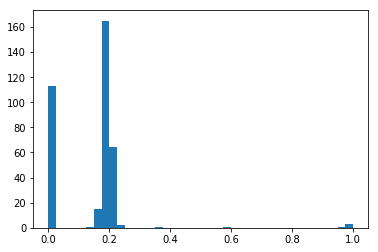

In [89]:
with active_session(): 
    plt.hist(missing_values_in_each_column, bins=40)

In [90]:
 
drop_missing_values_in_each_column = missing_values_in_each_column[missing_values_in_each_column > 0.25].index
differences=set(drop_missing_values_in_each_column) - set(feat_that_werent_described)
drop_missing_values_in_each_column = list(differences)
drop_missing_values_in_each_column

['KK_KUNDENTYP']

In [91]:
with active_session(): 
    mailout_training_df = clean_this_dataframe(mailout_train, feature_information, feat_that_werent_described, drop_missing_values_in_each_column)


In [92]:
with active_session(): 
    print("the shape of our new dataframe is",mailout_training_df.shape)

the shape of our new dataframe is (42962, 331)


In [93]:
type(mailout_training_df)

pandas.core.frame.DataFrame

In [94]:
with active_session(): 
    imputer = Imputer(strategy='median')
    scaler = StandardScaler()

In [95]:
with active_session(): 
    imputed_mailout_training_df = pd.DataFrame(imputer.fit_transform(mailout_training_df))
    scaled_mailout_training_df = scaler.fit_transform(imputed_mailout_training_df)

In [96]:

 
imputed_mailout_training_df.head()

,0,1,2,3,4,5,6,7,8,9,...,321,322,323,324,325,326,327,328,329,330
0,2.0,8.0,8.0,15.0,0.0,0.0,1.0,13.0,0.0,3.0,...,3.0,3.0,2.0,4.0,1.0,0.0,0.0,0.0,3.0,4.0
1,1.0,13.0,13.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0,...,7.0,1.0,2.0,3.0,1.0,0.0,3.0,0.0,3.0,2.0
2,1.0,9.0,7.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,...,2.0,3.0,1.0,4.0,0.0,0.0,0.0,1.0,1.0,4.0
3,2.0,6.0,6.0,4.0,0.0,0.0,2.0,4.0,0.0,4.0,...,1.0,3.0,2.0,4.0,1.0,0.0,0.0,1.0,1.0,4.0
4,2.0,9.0,9.0,53.0,0.0,0.0,1.0,44.0,0.0,3.0,...,3.0,3.0,1.0,3.0,1.0,0.0,1.0,0.0,4.0,1.0


In [97]:
with active_session(): 
    scaled_mailout_training=scaled_mailout_training_df #turns out that wasnt a dataframe :D

In [98]:
'''lets try out a few classification models now without tunning them'''

'lets try out a few classification models now without tunning them'

In [99]:
with active_session():
    def find_the_best_estimator(classifier, parameters={}, X_training_dataframe=scaled_mailout_training, y_train_dataframe=response_column):
        """

        this function takes a clssifier ,performs a grid search,prints the best score and then at the end returns the best classifier

        INPUT:
        - classifier (classifier): classifier that we are using to perform grid search with

        - parameters (dictionary): these are the performance parameters for which grid search is run

        - X_training_dataframe (DataFrame): these are the training data for which the grid object is fit

        - y_train_dataframe (DataFrame): these are the output values for it

        OUTPUT:

        - classifier: the best estimator
        """

        with active_session():
            grid = GridSearchCV(estimator=classifier, param_grid=parameters, scoring='roc_auc', cv=5)
            grid.fit(X_training_dataframe, y_train_dataframe)
            print("the best score is",grid.best_score_)

        return grid.best_estimator_

In [98]:
with active_session():    
    LogisticRegression = LogisticRegression(random_state=12)
    find_the_best_estimator(LogisticRegression)

the best score is 0.737154191316


In [99]:
 with active_session():
    BaggingClassifier = BaggingClassifier(random_state=12)
    find_the_best_estimator(BaggingClassifier)

the best score is 0.575484853724


In [100]:
with active_session():
    RandomForestClassifier = RandomForestClassifier(random_state=12)
    find_the_best_estimator(RandomForestClassifier)

the best score is 0.550600827625


In [101]:
with active_session():
    AdaBoostClassifier = AdaBoostClassifier(random_state=12)
    find_the_best_estimator(AdaBoostClassifier)

the best score is 0.74375389218


In [102]:
 with active_session():
    gbc = GradientBoostingClassifier(random_state=12)
    find_the_best_estimator(gbc)

the best score is 0.760801959266


In [103]:
with active_session():   
    LinearRegression = LinearRegression()
    find_the_best_estimator(LinearRegression)

the best score is 0.73114133304


# turns out GradientBoostingClassifier out performs the others

In [100]:
with active_session():    
   # GradientBoostingClassifier = GradientBoostingClassifier(random_state=12)
#now that we know which the best performing model is, we ll use gridsearch to optimise it using the below parameter_list
    gradbc = GradientBoostingClassifier(random_state=12)



    
    parameters_grid_dict = {'loss': ['deviance', 'exponential'],
                  'max_depth': [2, 3, 4],
                  'n_estimators':[100,150],
                  'random_state': [12]
                 }



    gradbc_best_est = find_the_best_estimator(gradbc, parameters_grid_dict)
    gradbc_best_est

the best score is 0.771591564746


In [101]:
len(gradbc_best_est.feature_importances_)

331

# lets see what this model thinks the most important features are

In [102]:
with active_session():   
    feature_importance = pd.DataFrame({'feature_importance':gradbc_best_est.feature_importances_}, index=mailout_training_df.columns)
    # lets sort those values now
    feature_importance_sorted = feature_importance.sort_values(by=['feature_importance'], ascending=False)
    '''top 5 values are'''
    feature_importance_sorted.head(5)

# feature selection
our model has been trained and optimised, now what according to the model are the most important features that it has seen

In [118]:
 feature_importance_sorted.head(5)

,feature_importance
D19_SOZIALES,0.156530
ANZ_KINDER,0.073850
D19_BANKEN_LOKAL,0.066922
D19_GARTEN,0.047969
GEBURTSJAHR,0.031520


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [103]:
with active_session():
    mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [104]:

mailout_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42833 entries, 0 to 42832
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 119.6+ MB


In [105]:

mailout_test.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,42833.000000,42833.000000,35944.000000,35944.000000,2013.000000,762.000000,201.000000,39.000000,34715.000000,35206.000000,...,34530.000000,35658.000000,35658.000000,35658.000000,33214.000000,35944.000000,35206.000000,42833.000000,42833.000000,42833.000000
mean,42993.165620,0.537436,1.518890,10.239511,12.534029,13.942257,14.442786,14.410256,9.822584,6.749986,...,2.372401,4.308682,4.488474,3.090078,4.489282,8.727437,4.088280,2.800037,1.595475,3.220484
std,24755.599728,1.414777,1.737441,6.109680,3.996079,3.142155,2.787106,2.279404,4.410937,14.839779,...,1.151531,3.169149,3.274829,2.510134,1.886903,1.013702,2.053977,1.120624,0.490806,1.069753
min,2.000000,-1.000000,1.000000,0.000000,2.000000,4.000000,6.000000,9.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,21650.000000,-1.000000,1.000000,8.000000,9.000000,12.000000,13.000000,13.000000,8.000000,1.000000,...,2.000000,1.000000,2.000000,1.000000,3.000000,9.000000,3.000000,3.000000,1.000000,3.000000
50%,43054.000000,1.000000,1.000000,10.000000,13.000000,14.000000,15.000000,14.000000,10.000000,2.000000,...,2.000000,3.000000,4.000000,2.000000,6.000000,9.000000,3.000000,3.000000,2.000000,4.000000
75%,64352.000000,2.000000,1.000000,15.000000,16.000000,17.000000,17.000000,16.000000,13.000000,7.000000,...,3.000000,7.000000,7.000000,4.000000,6.000000,9.000000,7.000000,3.000000,2.000000,4.000000
max,85794.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,379.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [106]:

mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


## lets begin the data preprocessing

In [107]:
lnr_col = mailout_test.LNR

In [108]:
with active_session():
    mailout_test = clean_this_dataframe(mailout_test, feature_information, feat_that_werent_described, drop_missing_values_in_each_column)
    print("the dimensions of this data frame are",mailout_test.shape)

the dimensions of this data frame are (42833, 331)


In [109]:
mailout_test.head()

,AGER_TYP,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,W,nan,DECADE_NEW,MOVEMENT_NEW,WEALTH_NEW,LIFE_STAGE_NEW
0,2.0,7.0,6.0,2.0,0.0,0.0,2.0,2.0,0.0,3.0,...,3.0,3,1,4.0,1,0,0.0,1.0,1.0,3.0
1,NaN,NaN,0.0,20.0,0.0,0.0,1.0,21.0,0.0,4.0,...,5.0,3,1,4.0,1,0,2.0,0.0,3.0,1.0
2,2.0,16.0,11.0,2.0,0.0,0.0,4.0,2.0,0.0,4.0,...,4.0,3,2,4.0,1,0,2.0,1.0,4.0,1.0
3,NaN,NaN,0.0,1.0,0.0,0.0,0.0,1.0,0.0,4.0,...,2.0,3,2,4.0,0,0,2.0,0.0,1.0,3.0
4,1.0,21.0,13.0,1.0,0.0,0.0,4.0,1.0,0.0,3.0,...,7.0,4,2,4.0,1,0,3.0,0.0,3.0,1.0


In [110]:
with active_session():
    imputed_mailout_test = pd.DataFrame(imputer.transform(mailout_test))
    scaled_mailout_test = scaler.transform(imputed_mailout_test)

we earlier trained a model in part 2 now we shall use it run CLASSIFICATION  

In [111]:
with active_session():   
    test_results = gradbc_best_est.predict_proba(scaled_mailout_test)
    

In [112]:
test_results

array([[ 0.96729698,  0.03270302],
       [ 0.96788487,  0.03211513],
       [ 0.99774302,  0.00225698],
       ..., 
       [ 0.98162739,  0.01837261],
       [ 0.97144039,  0.02855961],
       [ 0.97920803,  0.02079197]])

the resulting data was stored in a csv file called final_submission,lets see what the output csv looks like

In [113]:
with active_session():    
    final_submission = pd.DataFrame({'LNR':lnr_col, 'response':test_results[:,0]})
    final_submission.to_csv(path_or_buf='./final_submission.csv', index=False)


In [114]:

final_submission.head()

,LNR,response
0,1754,0.967297
1,1770,0.967885
2,1465,0.997743
3,1470,0.998265
4,1478,0.998720


In [115]:

final_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42833 entries, 0 to 42832
Data columns (total 2 columns):
LNR         42833 non-null int64
response    42833 non-null float64
dtypes: float64(1), int64(1)
memory usage: 669.3 KB


In [116]:

final_submission.describe()

,LNR,response
count,42833.000000,42833.000000
mean,42993.165620,0.989145
std,24755.599728,0.012489
min,2.000000,0.855947
25%,21650.000000,0.986503
50%,43054.000000,0.996389
75%,64352.000000,0.997633
max,85794.000000,0.999510


In [117]:
final_submission

,LNR,response
0,1754,0.967297
1,1770,0.967885
2,1465,0.997743
3,1470,0.998265
4,1478,0.998720
5,1782,0.997702
6,1485,0.998074
7,1519,0.974986
8,1835,0.979339
9,1522,0.997238
